# 상품 간 연관성 분석
- 판매되는 상품의 경향성에 대해 탐색합니다.
- '기저귀와 맥주는 함께 팔리는 경향이 있다'는 사실에서 시작된 분석입니다.
- 장바구니 분석(Market Basker Analysis)을 통해 수치적으로 경향을 살펴볼 수 있으며, 이를 상품 추천 모델에 반영하고자 합니다.

## import & load data

In [1]:
import numpy as np 
import pandas as pd 
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
import itertools

import warnings
import math
warnings.filterwarnings('ignore')
from tqdm import tqdm_notebook as tq

# 장바구니 분석 라이브러리
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import networkx as nx

# 시각화
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import missingno as msno
import seaborn as sns
sns.set_style('whitegrid')
path = 'C:/Windows/Fonts/malgun.ttf'
font_name = fm.FontProperties(fname=path, size=50).get_name()
plt.rc('font', family=font_name)
%matplotlib inline

In [3]:
cks_dtype = {'clnt_id':'int64','sess_id':'int64','hit_seq':'int64','action_type':'int64','biz_unit':'category','sess_dt':'object','hit_tm':'object',
             'hit_pss_tm':'int64','trans_id':'float64','sech_kwd':'object','tot_pag_view_ct':'float64','tot_sess_hr_v':'float64','trfc_src':'category',
             'dvc_ctg_nm':'object','pd_c':'object','de_dt':'object','de_tm':'object','buy_am':'int64','buy_ct':'int64','clnt_gender':'category',
             'clnt_age':'category'}
df1online = pd.read_csv('./DATA/온라인 행동 정보(CKS).csv', dtype=cks_dtype)
df2trade = pd.read_csv('./DATA/거래 정보(CKS).csv', dtype=cks_dtype)
df3custom = pd.read_csv('./DATA/고객 정보(CKS).csv', dtype=cks_dtype)
df4item = pd.read_csv('./DATA/상품분류 정보(CKS).csv', dtype=cks_dtype)

# data organization

## df3_known
- 고객정보데이터(df3custom)에서 unknown과 10대를 제외한 데이터
    - 이 데이터에 `clnt_type`을 부여
    - 부여한 `clnt_type`을 `clnt_id`를 기준으로 온라인행동데이터(df1online)에 join할 예정

In [4]:
df3_known = df3custom[~df3custom['clnt_gender'].isnull()] # 회원만(비회원 제외)
df3_known = df3_known[df3_known['clnt_age'] != 10].reset_index(drop = True) # 10대 제거
print(df3_known.shape)
df3_known.head()

(12245, 3)


,clnt_id,clnt_gender,clnt_age
0,2,F,30.0
1,9,F,40.0
2,12,F,40.0
3,20,F,30.0
4,22,M,30.0


In [5]:
df3_known['clnt_type'] = 0 # clnt_type 컬럼 생성: 연령과 성별을 고려한 10개의 클래스(20대여성, 30대여성, ... , 60대여성... , 20대남성, 30대남성, .. , 60대남성)

genders = ['F', 'M']
age_group = ['20.0', '30.0', '40.0', '50.0', '60.0']
k = 0

for gender in genders:
    for age in age_group:
        temp = df3_known[(df3_known['clnt_gender']==gender) & (df3_known['clnt_age'] == age)].index
        df3_known.loc[temp, 'clnt_type'] = k
        k+=1

df3_known['clnt_type'].value_counts()

2    4200
1    3680
3    1435
0     808
7     748
6     627
8     259
4     241
5     162
9      85
Name: clnt_type, dtype: int64

## df_transO
- 온라인행동데이터에서 거래 정보가 존재하는 고객만을 추려낸 데이터입니다.

In [6]:
df1_known = df1online[df1online['clnt_id'].isin(df3_known['clnt_id'].to_list())] # 회원에 대해서 접근(비회원 제외)
df1_known = df1_known.sort_values(by = ['clnt_id', 'sess_id', 'hit_seq']).reset_index(drop = True) # 데이터 정렬
df1_known.head()

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,tot_pag_view_ct,tot_sess_hr_v,trfc_src,dvc_ctg_nm
0,2,1,1,0,A03,20190728,23:35,39532,NaN,레쓰비,61.0,911.0,DIRECT,unknown
1,2,1,2,1,A03,20190728,23:35,47232,NaN,NaN,61.0,911.0,DIRECT,unknown
2,2,1,3,2,A03,20190728,23:35,48087,NaN,NaN,61.0,911.0,DIRECT,unknown
3,2,1,4,0,A03,20190728,23:35,62794,NaN,레쓰비,61.0,911.0,DIRECT,unknown
4,2,1,5,0,A03,20190728,23:36,104074,NaN,레쓰비,61.0,911.0,DIRECT,unknown


In [7]:
# 거래정보(trans_id)를 적어도 하나 가지고있는(결측값이 아닌) 세션만을 가져오기 위한 사용자정의함수입니다.

# determine function
def det_(df):
    nrows = df.shape[0]
    if df['trans_id'].isnull().value_counts().iloc[0] != nrows:
        return df

In [8]:
# trans_id 가 있는 세션만 가져옴
df1_transO = df1_known.groupby(['clnt_id', 'sess_id']).apply(lambda x : det_(x))
df1_transO.reset_index(drop = True, inplace = True) # 인데스 초기화
df1_transO.head()

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,tot_pag_view_ct,tot_sess_hr_v,trfc_src,dvc_ctg_nm
0,2,1,1,0,A03,20190728,23:35,39532,NaN,레쓰비,61.0,911.0,DIRECT,unknown
1,2,1,2,1,A03,20190728,23:35,47232,NaN,NaN,61.0,911.0,DIRECT,unknown
2,2,1,3,2,A03,20190728,23:35,48087,NaN,NaN,61.0,911.0,DIRECT,unknown
3,2,1,4,0,A03,20190728,23:35,62794,NaN,레쓰비,61.0,911.0,DIRECT,unknown
4,2,1,5,0,A03,20190728,23:36,104074,NaN,레쓰비,61.0,911.0,DIRECT,unknown


## df2_df4
- 거래정보데이터에는 구매한 상품에 대한 정보가 담겨있지 않습니다.
- `df2_df4`데이터는 거래정보데이터에 구매 상품 정보를 추가한 데이터입니다.

In [9]:
df2_df4 = df2trade.merge(df4item, how = 'left') # 거래 데이터에 구매 상품에 대한 정보를 merging
df2_df4.head()

,clnt_id,trans_id,trans_seq,biz_unit,pd_c,de_dt,de_tm,buy_am,buy_ct,clac_nm1,clac_nm2,clac_nm3
0,2,42449.0,1,A02,1015.0,20190704,15:34,46430,1,Men's Clothing,Men's Upper Bodywear / Tops,Men's T-shirts
1,2,62037.0,1,A03,92.0,20190729,23:47,36000,20,Beverages,Coffee Drinks,Coffee Drinks
2,2,64691.0,1,A03,186.0,20190731,21:25,3790,1,Chilled Foods,Fish Cakes and Crab Sticks,Crab Sticks
3,2,64691.0,2,A03,151.0,20190731,21:25,3990,1,Canned / Jarred Foods,Canned Agricultural Foods,Canned Vegetable Foods
4,2,64691.0,3,A03,351.0,20190731,21:25,4690,1,Dairy Products,Processed Dairy Products,Cream and Condensed milk


## for_asso
- 장바구니 분석을 위한 데이터셋
- `df1_transO`데이터와 `df2_df4`데이터를 병합
    - 즉, 회원 고객의 온라인 행동 정보와 거래 정보, 구매 상품 정보가 모두 담긴 데이터셋

In [10]:
for_asso = df1_transO.merge(df2_df4, how = 'inner', on = ['clnt_id', 'trans_id'])
for_asso.head()

,clnt_id,sess_id,hit_seq,action_type,biz_unit_x,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,tot_pag_view_ct,tot_sess_hr_v,trfc_src,dvc_ctg_nm,trans_seq,biz_unit_y,pd_c,de_dt,de_tm,buy_am,buy_ct,clac_nm1,clac_nm2,clac_nm3
0,2,1,37,6,A03,20190728,23:47,791905,62037.0,NaN,61.0,911.0,DIRECT,unknown,1,A03,92.0,20190729,23:47,36000,20,Beverages,Coffee Drinks,Coffee Drinks
1,2,8,68,6,A03,20190731,21:25,3251794,64691.0,NaN,85.0,3256.0,DIRECT,unknown,1,A03,186.0,20190731,21:25,3790,1,Chilled Foods,Fish Cakes and Crab Sticks,Crab Sticks
2,2,8,68,6,A03,20190731,21:25,3251794,64691.0,NaN,85.0,3256.0,DIRECT,unknown,2,A03,151.0,20190731,21:25,3990,1,Canned / Jarred Foods,Canned Agricultural Foods,Canned Vegetable Foods
3,2,8,68,6,A03,20190731,21:25,3251794,64691.0,NaN,85.0,3256.0,DIRECT,unknown,3,A03,351.0,20190731,21:25,4690,1,Dairy Products,Processed Dairy Products,Cream and Condensed milk
4,2,8,68,6,A03,20190731,21:25,3251794,64691.0,NaN,85.0,3256.0,DIRECT,unknown,4,A03,189.0,20190731,21:25,4290,1,Chilled Foods,Fish Cakes and Crab Sticks,Fried Tofu


# 장바구니 분석(Market Basket Analysis)
- Association Rules로도 부릅니다.
- 장바구니 분석에는 세 가지 수치적 지표가 활용됩니다.
    - `지지도(Support)`: `(상품 A와 B가 동시에 포함된 사례 수) / (전체 사례 수)`, P(A∩B)
    - `신뢰도(Confidence)`: `(상품 A와 B가 동시에 포함된 사례 수) / (상품 A가 포함된 사례 수)`, P(A∩B) / P(A)
    - `향상도(Lift)`: `상품 A가 없을 때 상품 B가 있을 확률`과 `상품 A가 있을 때 상품 B가 있을 확률의 비율`, P(A∩B) / P(A)*P(B)  = P (B|A) / P (B)
        - 상품 간 상호 관계가 없으면 1, 1보다 크거나 작으면 random chance가 아닌 것으로 해석
- *\"어떤 상품을 살 때 이것도 같이 사더라\"*의 조건부 확률 개념에 착안하여 `신뢰도(Confidence)`를 기반으로 분석을 진행합니다.

- reference
    - https://brunch.co.kr/@rapaellee/9
    - https://pyopyo03.tistory.com/14

In [14]:
# 세션 내 어떤 상품을 구매했는지 하나의 리스트로 반환하는 함수
# 예: 철수가 1번 세션에서 사과, 우유, 과자를 구매
    # 결과값: [사과, 우유, 과자]
# 하나의 리스트로 반환하여 판매되는 상품 간 연관성을 분석
    # 기저귀와 맥주가 함께 많이 팔리는 경향처럼, 이러한 인사이트를 도출
def buywhat_clac1(x):
    df = x
    idx = df[~df['trans_id'].isnull()].index.to_list()
    emp = []
    for i in idx:
        emp.append(df.loc[idx, 'clac_nm1'].to_list())
    return flatten(emp)

# 여러 겹의 리스트를 한 겹의 리스트로 반환하는 함수
def flatten (n):
    org =[]
    for i in n :
        if (isinstance(i,list)):
            org += flatten(i)
        else:
            org.append(i)
    return org

In [15]:
# 세션별 구매물품 대분류 및 소분류
df_clac1_list = for_asso.groupby(['clnt_id', 'sess_id']).apply(lambda x: buywhat_clac1(x)).to_frame('구매물품 clac1')

In [16]:
for_asso2 = for_asso[['clnt_id','sess_id']]
for_asso2 = for_asso2.merge(df_clac1_list.reset_index(), how = 'left', on = ['clnt_id', 'sess_id'])
for_asso2 = for_asso2.groupby(['clnt_id', 'sess_id'], as_index = False).first()

In [17]:
clac1 = for_asso2['구매물품 clac1'].to_list()

clac1_copy = clac1[:]
clac1_refined =  []

for idx in range(len(clac1_copy)):
    temp = []
    for j in clac1_copy[idx]:
        if isinstance(j, float)==False:
            temp.append(j)
    clac1_refined.append(temp)

print(len(clac1_refined))

20766


In [18]:
te_clac1 = TransactionEncoder()
te_ary_clac1 = te_clac1.fit(clac1_refined).transform(clac1_refined)
df = pd.DataFrame(te_ary_clac1, columns=te_clac1.columns_) #위에서 나온걸 보기 좋게 데이터프레임으로 변경
df.shape

(20766, 56)

In [19]:
frequent_itemsets_clac1 = apriori(df, min_support=0.005, use_colnames=True) # min_support : 최소 지지도
frequent_itemsets_clac1.describe()

,support
count,1493.000000
mean,0.020636
std,0.031973
min,0.005008
25%,0.006742
50%,0.010209
75%,0.019888
max,0.356544


In [23]:
asso_clac_1 = association_rules(frequent_itemsets_clac1, metric="confidence", min_threshold=0.1).sort_values(by = ['antecedents', 'consequents', 'confidence'])
asso_confidence = asso_clac_1[['antecedents', 'consequents', 'confidence']].sort_values(by = 'confidence', ascending = False)

`신뢰도(Confidence)`를 살펴본 결과는 다음과 같음
- 아래의 1918 인덱스의 샘플의 경우, `육류와 조미료`를 구매하면, `야채`를 함께 구매할 확률이 약 63%에 이른다고 분석할 수 있습니다.
- 이러한 결과가 나온 것을 보고 데이터의 몇몇 고객을 살펴보니, 실제로 이러한 경우가 다수 발견되었습니다.

In [24]:
asso_confidence.head(200).tail(100)

,antecedents,consequents,confidence
1918,"(Meats, Spices / Seasonings)",(Vegetables),0.639153
4960,"(Chilled Foods, Vegetables, Grains)",(Meats),0.639053
5340,"(Dried Sea Foods, Dairy Products, Spices / Sea...",(Meats),0.639024
1174,"(Spices / Seasonings, Coffee / Tea)",(Substitute Foods),0.638498
6079,"(Fruits, Dried Sea Foods, Snack Foods)",(Vegetables),0.637755
1791,"(Fruits, Meats)",(Vegetables),0.637270
10508,"(Meats, Chilled Foods, Spices / Seasonings, Sn...",(Vegetables),0.637168
10551,"(Meats, Substitute Foods, Spices / Seasonings,...",(Vegetables),0.636917
3670,"(Canned / Jarred Foods, Dairy Products, Vegeta...",(Meats),0.636364
8467,"(Fruits, Meats, Canned / Jarred Foods, Chilled...",(Dairy Products),0.636364


- clnt_id가 1176인 고객

In [27]:
for_asso2.loc[203, :]

clnt_id                                                    1176
sess_id                                                      17
구매물품 clac1    [Vegetables, Chilled Foods, Dairy Products, Ch...
Name: 203, dtype: object

In [25]:
for_asso2.loc[203, :]['구매물품 clac1']

['Vegetables',
 'Chilled Foods',
 'Dairy Products',
 'Chilled Foods',
 'Dairy Products',
 'Meats',
 'Fruits',
 'Frozen Foods',
 'Dairy Products',
 'Vegetables',
 'Chilled Foods',
 'Dairy Products',
 'Chilled Foods',
 'Dairy Products',
 'Meats',
 'Fruits',
 'Frozen Foods',
 'Dairy Products',
 'Vegetables',
 'Chilled Foods',
 'Dairy Products',
 'Chilled Foods',
 'Dairy Products',
 'Meats',
 'Fruits',
 'Frozen Foods',
 'Dairy Products',
 'Vegetables',
 'Chilled Foods',
 'Dairy Products',
 'Chilled Foods',
 'Dairy Products',
 'Meats',
 'Fruits',
 'Frozen Foods',
 'Dairy Products',
 'Vegetables',
 'Chilled Foods',
 'Dairy Products',
 'Chilled Foods',
 'Dairy Products',
 'Meats',
 'Fruits',
 'Frozen Foods',
 'Dairy Products',
 'Vegetables',
 'Chilled Foods',
 'Dairy Products',
 'Chilled Foods',
 'Dairy Products',
 'Meats',
 'Fruits',
 'Frozen Foods',
 'Dairy Products',
 'Vegetables',
 'Chilled Foods',
 'Dairy Products',
 'Chilled Foods',
 'Dairy Products',
 'Meats',
 'Fruits',
 'Frozen Foods

In [20]:
for_asso2.loc[1787, :].to_frame()

,1787
clnt_id,8357
sess_id,5
구매물품 clac1,[Cell Phones / Accessories]


- 50번의 고객ID의 경우 야채와 고기를 함께 사는 경향을 보인다.

In [26]:
for_asso2[(for_asso2['clnt_id'] == 49) & (for_asso2['sess_id'] == 40)]['구매물품 clac1'].to_list()

[['Vegetables',
  'Vegetables',
  'Meats',
  'Vegetables',
  'Dairy Products',
  'Substitute Foods',
  'Meats',
  'Fruits',
  'Vegetables',
  'Vegetables',
  'Meats',
  'Vegetables',
  'Dairy Products',
  'Substitute Foods',
  'Meats',
  'Fruits',
  'Vegetables',
  'Vegetables',
  'Meats',
  'Vegetables',
  'Dairy Products',
  'Substitute Foods',
  'Meats',
  'Fruits',
  'Vegetables',
  'Vegetables',
  'Meats',
  'Vegetables',
  'Dairy Products',
  'Substitute Foods',
  'Meats',
  'Fruits',
  'Vegetables',
  'Vegetables',
  'Meats',
  'Vegetables',
  'Dairy Products',
  'Substitute Foods',
  'Meats',
  'Fruits',
  'Vegetables',
  'Vegetables',
  'Meats',
  'Vegetables',
  'Dairy Products',
  'Substitute Foods',
  'Meats',
  'Fruits',
  'Vegetables',
  'Vegetables',
  'Meats',
  'Vegetables',
  'Dairy Products',
  'Substitute Foods',
  'Meats',
  'Fruits',
  'Vegetables',
  'Vegetables',
  'Meats',
  'Vegetables',
  'Dairy Products',
  'Substitute Foods',
  'Meats',
  'Fruits']]

- 880번의 고객ID의 경우 야채와 해산물을 함께 사는 경향을 보인다.

In [22]:
for_asso2[(for_asso2['clnt_id'] == 880) & (for_asso2['sess_id'] == 7)]['구매물품 clac1'].to_list()

[['Vegetables',
  'Sea Foods',
  'Chilled Foods',
  'Substitute Foods',
  'Vegetables',
  'Meats',
  'Meats',
  'Chilled Foods',
  'Meats',
  'Fruits',
  'Vegetables',
  'Vegetables',
  'Vegetables',
  'Sea Foods',
  'Chilled Foods',
  'Substitute Foods',
  'Vegetables',
  'Meats',
  'Meats',
  'Chilled Foods',
  'Meats',
  'Fruits',
  'Vegetables',
  'Vegetables',
  'Vegetables',
  'Sea Foods',
  'Chilled Foods',
  'Substitute Foods',
  'Vegetables',
  'Meats',
  'Meats',
  'Chilled Foods',
  'Meats',
  'Fruits',
  'Vegetables',
  'Vegetables',
  'Vegetables',
  'Sea Foods',
  'Chilled Foods',
  'Substitute Foods',
  'Vegetables',
  'Meats',
  'Meats',
  'Chilled Foods',
  'Meats',
  'Fruits',
  'Vegetables',
  'Vegetables',
  'Vegetables',
  'Sea Foods',
  'Chilled Foods',
  'Substitute Foods',
  'Vegetables',
  'Meats',
  'Meats',
  'Chilled Foods',
  'Meats',
  'Fruits',
  'Vegetables',
  'Vegetables',
  'Vegetables',
  'Sea Foods',
  'Chilled Foods',
  'Substitute Foods',
  'Veget

In [23]:
for_asso2[(for_asso2['clnt_id'] == 624) & (for_asso2['sess_id'] == 2)]['구매물품 clac1'].to_list()

[['Vegetables',
  'Meats',
  'Meats',
  'Meats',
  'Dairy Products',
  'Meats',
  'Vegetables',
  'Detergents / Hygiene Goods',
  'Beverages',
  'Vegetables',
  'Meats',
  'Meats',
  'Meats',
  'Dairy Products',
  'Meats',
  'Vegetables',
  'Detergents / Hygiene Goods',
  'Beverages',
  'Vegetables',
  'Meats',
  'Meats',
  'Meats',
  'Dairy Products',
  'Meats',
  'Vegetables',
  'Detergents / Hygiene Goods',
  'Beverages',
  'Vegetables',
  'Meats',
  'Meats',
  'Meats',
  'Dairy Products',
  'Meats',
  'Vegetables',
  'Detergents / Hygiene Goods',
  'Beverages',
  'Vegetables',
  'Meats',
  'Meats',
  'Meats',
  'Dairy Products',
  'Meats',
  'Vegetables',
  'Detergents / Hygiene Goods',
  'Beverages',
  'Vegetables',
  'Meats',
  'Meats',
  'Meats',
  'Dairy Products',
  'Meats',
  'Vegetables',
  'Detergents / Hygiene Goods',
  'Beverages',
  'Vegetables',
  'Meats',
  'Meats',
  'Meats',
  'Dairy Products',
  'Meats',
  'Vegetables',
  'Detergents / Hygiene Goods',
  'Beverages',

# 고객 유형 X 구매 품목 간의  관계
- `고객 유형(clnt_type)`과 `구매 품목`간에 관계성을 탐색합니다.

In [12]:
known = df1online[df1online['clnt_id'].isin(df3_known['clnt_id'])].reset_index(drop=True)
known = known.merge(df3_known, how='left', on='clnt_id')

In [13]:
female = sns.color_palette('Reds',5)
male =  sns.color_palette('Blues',5)
palette = {0:female[0], 5:male[0],
           1:female[1], 6:male[1],
           2:female[2], 7:male[2],
           3:female[3], 8:male[3],
           4:female[4], 9:male[4]}

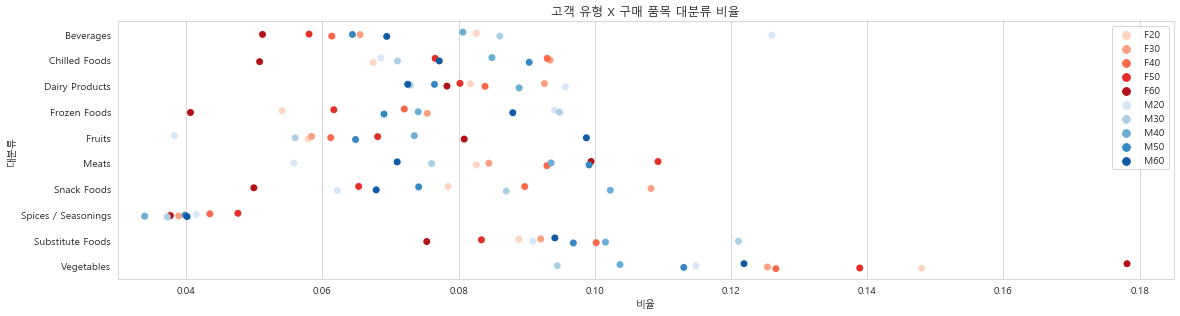

In [64]:
# purchase = known[known['action_type']==6]
# purchase_trade = purchase.merge(df2trade, how='left', on=['clnt_id','biz_unit','trans_id'])
# purchase_trade_item = purchase_trade.merge(df4item, how='left', on='pd_c')

# contain_nm1 = purchase_trade_item['clac_nm1'].value_counts().to_frame('count').reset_index()
# nm1s = contain_nm1.head(10)['index'].tolist()

# clnt_type_nm1 = purchase_trade_item.groupby(['clnt_type','clac_nm1']).size().to_frame('count').reset_index()
# type_total = clnt_type_nm1.groupby('clnt_type')['count'].sum().to_frame('total')
# clnt_type_nm1 = clnt_type_nm1.merge(type_total, how='left', on='clnt_type')
# clnt_type_nm1['ratio'] = clnt_type_nm1['count']/clnt_type_nm1['total']

# sample_1 = clnt_type_nm1[clnt_type_nm1['clac_nm1'].isin(nm1s)]

fig, ax = plt.subplots(figsize=(16.5,4.5))
sns.stripplot(data=sample_1, x='ratio', y='clac_nm1', hue='clnt_type', palette=palette, size = 7)

handles, labels = ax.get_legend_handles_labels()
type_labels=['F20','F30','F40','F50','F60','M20','M30','M40','M50','M60']
ax.legend(handles, type_labels, loc='upper right')

plt.title('고객 유형 X 구매 품목 대분류 비율')
plt.xlabel('비율'); plt.ylabel('대분류')
plt.xlim(0.03,0.185)

plt.tight_layout()
plt.savefig('./image/고객 유형 X 구매 품목 대분류 비율.png', dpi=300)
plt.show()

- 성별과 연령대에 따라 구매하는 상품이 다르게 나타남을 관찰할 수 있습니다.

# 키워드 X 구매 품목

키워드와 구매 품목의 종류가 너무 많기 때문에 기록된 수가 상위 10개의 키워드와 구매품목으로만 살펴봅니다.

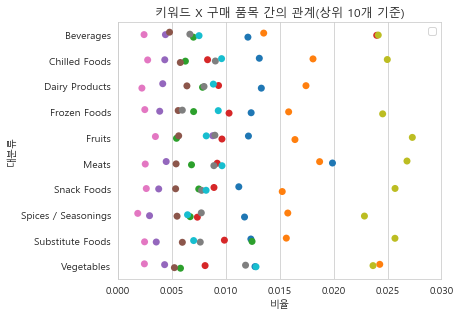

In [22]:
# contain_kwd = df1online['sech_kwd'].value_counts().to_frame('count').reset_index()
# kwds = contain_kwd.head(10)['index'].tolist()

# known_trade = known.merge(df2trade, how='left', on=['clnt_id','biz_unit','trans_id'])
# known_trade_item = known_trade.merge(df4item, how='left', on='pd_c')

# contain_nm1 = known_trade_item['clac_nm1'].value_counts().to_frame('count').reset_index()
# nm1s = contain_nm1.head(10)['index'].tolist()

# sess_kwd = known_trade_item.groupby(['clnt_id','sess_id'])['sech_kwd'].unique().to_frame().reset_index()
# sess_clac_nm1 = known_trade_item.groupby(['clnt_id','sess_id'])['clac_nm1'].unique().to_frame().reset_index()

# kwd_clac_nm1 = sess_kwd.copy()
# kwd_clac_nm1['clac_nm1'] = sess_clac_nm1['clac_nm1']
# kwd_clac_nm1 = kwd_clac_nm1[['sech_kwd','clac_nm1']]

# kwd, nm1 = [[],[]]
# for i in tq(range(len(kwd_clac_nm1))):
#     for j in kwd_clac_nm1.iloc[i,0]:
#         for k in kwd_clac_nm1.iloc[i,1]:
#             kwd.append(j)
#             nm1.append(k)
# output = pd.DataFrame({'kwd':kwd, 'nm1':nm1})
# output = output.dropna().reset_index(drop=True)

# kwd_nm1 = output.groupby(['kwd','nm1']).size().to_frame('count').reset_index()
# nm1_total = kwd_nm1.groupby('nm1')['count'].sum().to_frame('total').reset_index()
# kwd_nm1_total = kwd_nm1.merge(nm1_total, how='left', on='nm1')
# kwd_nm1_total['ratio'] = kwd_nm1_total['count']/kwd_nm1_total['total']

# sample_2 = kwd_nm1_total[(kwd_nm1_total['kwd'].isin(kwds))&(kwd_nm1_total['nm1'].isin(nm1s))]


fig, ax = plt.subplots(figsize=(6.5,4.5))
# fig, ax = plt.subplots(figsize=(15,4.5))
sns.stripplot(data=sample_2, x='ratio', y='nm1', hue='kwd', size = 7)
plt.legend('')
plt.xlim(0,0.03)
plt.title('키워드 X 구매 품목 간의 관계(상위 10개 기준)')
plt.xlabel('비율'); plt.ylabel('대분류')
plt.tight_layout()

plt.savefig('./image/키워드 X 구매 품목 간의 관계.png', dpi=300)
plt.show()

* 고객 검색 키워드와 구매 품목에도 몇몇 구별점이 발견되었습니다.

# 페이지 서핑 속도 X 구매 품목

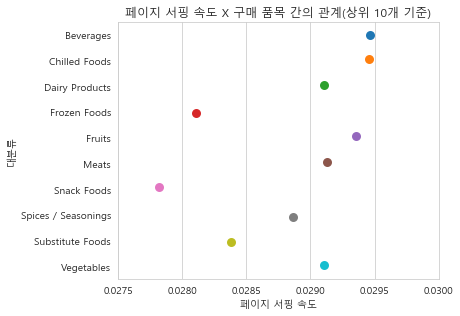

In [48]:
# purchase = known[known['action_type']==6]
# purchase_trade = purchase.merge(df2trade, how='left', on=['clnt_id','biz_unit','trans_id'])
# purchase_trade_item = purchase_trade.merge(df4item, how='left', on='pd_c')

# purchase_trade_item['pv_hr'] = purchase_trade_item['tot_pag_view_ct']/purchase_trade_item['tot_sess_hr_v']

# contain_nm1 = purchase_trade_item['clac_nm1'].value_counts().to_frame('count').reset_index()
# nm1s = contain_nm1.head(10)['index'].tolist()

# pv_hr_nm1 = purchase_trade_item.groupby('clac_nm1')['pv_hr'].median().to_frame('pv_hr').reset_index()
# sample_3 = pv_hr_nm1[pv_hr_nm1['clac_nm1'].isin(nm1s)]

fig, ax = plt.subplots(figsize=(6.5,4.5))
sns.stripplot(data=sample_3, x='pv_hr', y='clac_nm1', size = 9)

plt.title('페이지 서핑 속도 X 구매 품목 간의 관계(상위 10개 기준)')
plt.xlim(0.0275,0.03)
plt.xlabel('페이지 서핑 속도'); plt.ylabel('대분류')
plt.tight_layout()

plt.savefig('./image/페이지 서핑 속도 X 구매 품목 간의 관계.png', dpi=300)
plt.show()

* 구매한 상품에 따라 쇼핑 동안 페이지 서핑 속도가 다르게 관찰되었습니다.